<a href="https://colab.research.google.com/github/josematez/DeepLearning_SkinCancer/blob/main/Prueba_Paula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical 
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

sns.set(color_codes = True)

#Global Variables
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-']
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Proyecto Curso Samsung')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install numpy==1.15.4
!pip install deepdish

In [4]:
import deepdish as dd
data = dd.io.load('ISIC_dataset.h5')
data_df = pd.DataFrame(data)

In [5]:
X_raw = data_df.image
Y = data_df.cell_type_idx

In [6]:
X = np.zeros((10015, 75, 100, 3))

for i in range(10015):
  X[i,:,:,:] = X_raw[i]

In [7]:
print("Tamaño datos X: {}".format(X.shape))
print("Tamaño datos Y: {}".format(Y.shape))

Tamaño datos X: (10015, 75, 100, 3)
Tamaño datos Y: (10015,)


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 123)

In [9]:
X_train = (X_train / np.max(X_train))
X_test = (X_test / np.max(X_test))

In [10]:
Y_train = to_categorical(Y_train, num_classes = 7)
Y_test = to_categorical(Y_test, num_classes = 7)

In [11]:
input_shape = (75, 100, 3)
num_classes = 7

In [12]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(X_train)

In [28]:
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu',input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'same', activation = 'relu',input_shape = input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu',input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu',input_shape = input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu',input_shape = input_shape))
model.add(BatchNormalization())
model.add(Conv2D(filters = 256, kernel_size = (3,3), padding = 'same', activation = 'relu',input_shape = input_shape))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dense(512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes,activation = 'softmax'))
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [29]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 75, 100, 64)       1792      
_________________________________________________________________
batch_normalization_21 (Batc (None, 75, 100, 64)       256       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 75, 100, 64)       36928     
_________________________________________________________________
batch_normalization_22 (Batc (None, 75, 100, 64)       256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 37, 50, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 37, 50, 128)       73856     
_________________________________________________________________
batch_normalization_23 (Batc (None, 37, 50, 128)      

In [30]:
early_stop = EarlyStopping(monitor='val_loss', patience=6)
mod_chckpt = ModelCheckpoint(filepath='model_v1.h5', monitor='val_loss', save_best_only=True)

In [31]:
history = [0]
epochs = 50
batch_size = 100

history[0] = model.fit(X_train,Y_train, epochs = epochs, validation_split = 0.1,
                                verbose = 1, batch_size = batch_size, callbacks=[learning_rate_reduction, early_stop, mod_chckpt])

Epoch 1/50
64/64 [==============================] - 13s 200ms/step - loss: 1.6142 - accuracy: 0.6202 - val_loss: 1.5524 - val_accuracy: 0.6419
Epoch 2/50
64/64 [==============================] - 12s 184ms/step - loss: 0.8542 - accuracy: 0.7180 - val_loss: 2.3592 - val_accuracy: 0.1769
Epoch 3/50
64/64 [==============================] - 11s 179ms/step - loss: 0.7825 - accuracy: 0.7334 - val_loss: 1.5719 - val_accuracy: 0.6248
Epoch 4/50
63/64 [============================>.] - ETA: 0s - loss: 0.6800 - accuracy: 0.7583
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
64/64 [==============================] - 11s 176ms/step - loss: 0.6797 - accuracy: 0.7584 - val_loss: 2.8448 - val_accuracy: 0.1969
Epoch 5/50
64/64 [==============================] - 12s 192ms/step - loss: 0.5469 - accuracy: 0.8028 - val_loss: 1.3224 - val_accuracy: 0.6534
Epoch 6/50
64/64 [==============================] - 11s 175ms/step - loss: 0.4956 - accuracy: 0.8242 - val_loss: 1.5187 - 

In [32]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=1)
#loss_v, accuracy_v = model.evaluate(X_val, y_val, verbose=1)
#print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

94/94 [==============================] - 2s 18ms/step - loss: 0.8312 - accuracy: 0.7524
Test: accuracy = 0.752413  ;  loss = 0.831207


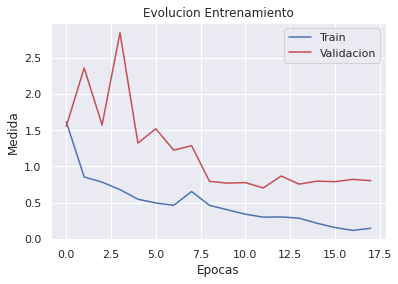

In [33]:
plt.plot(history[0].history['loss'], c = 'b')
plt.plot(history[0].history['val_loss'], c = 'r')
plt.legend(['Train', 'Validacion'])
plt.xlabel('Epocas')
plt.ylabel('Medida')
plt.title('Evolucion Entrenamiento')
plt.show()

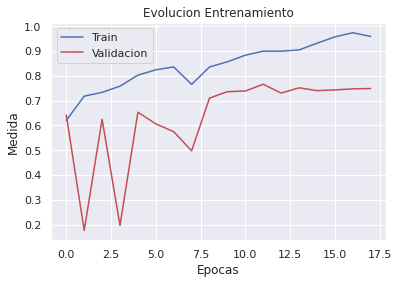

In [34]:
plt.plot(history[0].history['accuracy'], c = 'b')
plt.plot(history[0].history['val_accuracy'], c = 'r')
plt.legend(['Train', 'Validacion'])
plt.xlabel('Epocas')
plt.ylabel('Medida')
plt.title('Evolucion Entrenamiento')
plt.show()